# Predicting Molecular Properties
Can you measure the magnetic interactions between a pair of atoms?

In this competition, you will develop an algorithm that can predict the magnetic interaction between two atoms in a molecule (i.e., the scalar coupling constant).

![](http://www.chem.ucalgary.ca/courses/350/Carey5th/Ch13/coupling04.gif)

**NOTE : Some (but not all) of the text in this kernel was taken from the competition details. I do this to show exactly what the description and rules are for the competition alongside some exploritory code. Be sure to read the competition details yourself directly from the website here: https://www.kaggle.com/c/champs-scalar-coupling/overview/description. **

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# The Data

In this competition, you will be predicting the scalar_coupling_constant between atom pairs in molecules, given the two atom types (e.g., C and H), the coupling type (e.g., 2JHC), and any features you are able to create from the molecule structure (xyz) files.

For this competition, you will not be predicting all the atom pairs in each molecule rather, you will only need to predict the pairs that are explicitly listed in the train and test files. For example, some molecules contain Fluorine (F), but you will not be predicting the scalar coupling constant for any pair that includes F.

The training and test splits are by molecule, so that no molecule in the training data is found in the test data.

In [2]:
# Show how the files appear in the input folder
!ls -GFlash --color ../input

total 897M
4.0K drwxr-xr-x 3 root 4.0K May 29 22:00 ./
4.0K drwxr-xr-x 6 root 4.0K Jun  1 19:26 ../
3.2M -rw-r--r-- 1 root 3.2M May 29 21:34 dipole_moments.csv
131M -rw-r--r-- 1 root 131M May 29 21:35 magnetic_shielding_tensors.csv
 42M -rw-r--r-- 1 root  42M May 29 21:34 mulliken_charges.csv
2.2M -rw-r--r-- 1 root 2.2M May 29 21:34 potential_energy.csv
 24M -rw-r--r-- 1 root  24M May 29 21:34 sample_submission.csv
280M -rw-r--r-- 1 root 280M May 29 21:35 scalar_coupling_contributions.csv
5.1M drwxr-xr-x 2 root 5.1M May 29 21:59 structures/
136M -rw-r--r-- 1 root 136M May 29 21:35 structures.csv
 84M -rw-r--r-- 1 root  84M May 29 22:00 test.csv
192M -rw-r--r-- 1 root 192M May 29 22:00 train.csv


## train.csv and test.csv
The training set, where the first column `molecule_name` is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second `atom_index_0` and third column `atom_index_1` is the atom indices of the atom-pair creating the coupling and the fourth column `scalar_coupling_constant` is the scalar coupling constant that we want to be able to predict

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

We can see each observation provides the:
- molecule_name
- atom_index_0 - index of the first atom pair
- atom_index_1 - index of the second atom pair
- scalar_coupling_constant (target)

In [4]:
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


The training set is larger than the test set.


In [5]:
print('The training set has shape {}'.format(train_df.shape))
print('The test set has shape {}'.format(test_df.shape))

The training set has shape (4658147, 6)
The test set has shape (2505542, 5)


The target distribution is pretty interesting! Spikes near zero, and -20. There is also a good bit around 80. We will return to these files later.

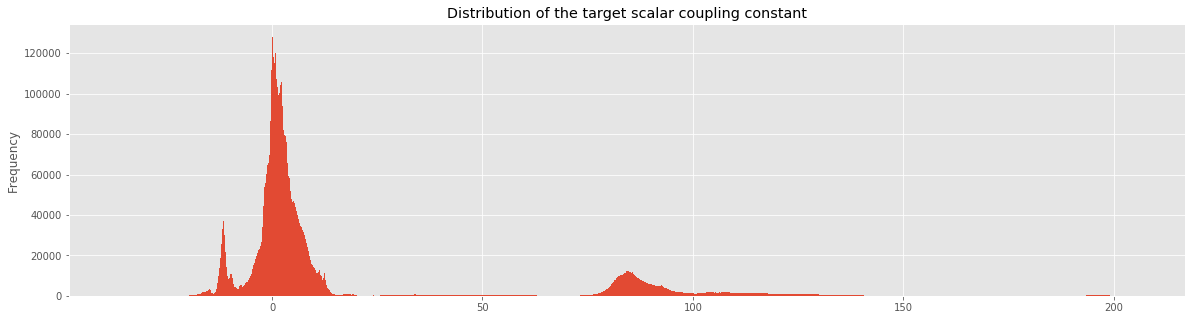

In [6]:
# Distribution of the target
train_df['scalar_coupling_constant'].plot(kind='hist', figsize=(20, 5), bins=1000, title='Distribution of the target scalar coupling constant')
plt.show()

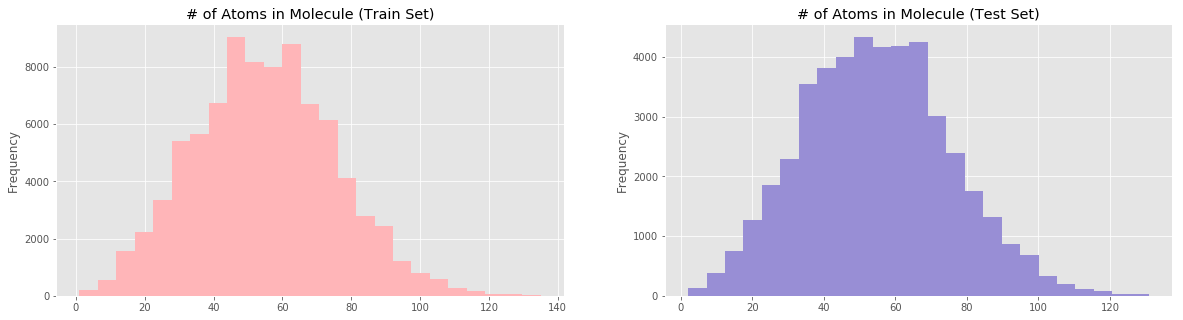

In [7]:
# Number of of atoms in molecule
fig, ax = plt.subplots(1, 2)
train_df.groupby('molecule_name').count().sort_values('id')['id'].plot(kind='hist',
                                                                       bins=25,
                                                                       color=color_pal[6],
                                                                      figsize=(20, 5),
                                                                      title='# of Atoms in Molecule (Train Set)',
                                                                      ax=ax[0])
test_df.groupby('molecule_name').count().sort_values('id')['id'].plot(kind='hist',
                                                                       bins=25,
                                                                       color=color_pal[2],
                                                                      figsize=(20, 5),
                                                                      title='# of Atoms in Molecule (Test Set)',
                                                                     ax=ax[1])
plt.show()

## sample_submission file
We are predicting for a given `id` found in the test set. The id corresponds with a given `molecule_name`

In [8]:
ss = pd.read_csv('../input/sample_submission.csv')
ss.head()

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0


We can see in the test set each molicule name is associated with an id.

In [9]:
test_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


## structures.zip annd structures csv files.
folder containing molecular structure (xyz) files, where: 
- the first line is the number of atoms in the molecule,
- followed by a blank line
- and then a line for every atom, where the first column contains the atomic element (H for hydrogen, C for carbon etc.) and the remaining columns contain the X, Y and Z cartesian coordinates (a standard format for chemists and molecular visualization programs)


...lets have a look at the first example from the training set!

In [10]:
train_df.head(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076


## Look at the xyz file for this example
- The first number `5` is the number of atoms in this molecule.
- A blank line....
- Each following line is the element and their cartesian coordinates. So in this examples we have one Carbon atom and four Hydrogen atoms!

In [11]:
! cat ../input/structures/dsgdb9nsd_000001.xyz

5

C -0.0126981359 1.0858041578 0.0080009958
H 0.0021504160 -0.0060313176 0.0019761204
H 1.0117308433 1.4637511618 0.0002765748
H -0.5408150690 1.4475266138 -0.8766437152
H -0.5238136345 1.4379326443 0.9063972942

## Structures.csv
This file contains the same information as the individual xyz structure files, but in a single file.

At first glance - this csv seems a lot more useable than the `xyz` files

In [12]:
structures = pd.read_csv('../input/structures.csv')
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


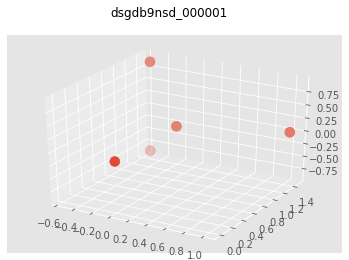

In [13]:
# 3D Plot!
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
example = structures.loc[structures['molecule_name'] == 'dsgdb9nsd_000001']
ax.scatter(xs=example['x'], ys=example['y'], zs=example['z'], s=100)
plt.suptitle('dsgdb9nsd_000001')
plt.show()

# Additional Data
*NOTE: additional data is provided for the molecules in Train only!*



## dipole_moments.csv
- contains the molecular electric dipole moments. These are three dimensional vectors that indicate the charge distribution in the molecule. The first column (molecule_name) are the names of the molecule, the second to fourth column are the X, Y and Z components respectively of the dipole moment.

In [14]:
dm = pd.read_csv('../input/dipole_moments.csv')
dm.head()

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000


## magnetic_shielding_tensors.csv
- contains the magnetic shielding tensors for all atoms in the molecules. The first column (molecule_name) contains the molecule name, the second column (atom_index) contains the index of the atom in the molecule, the third to eleventh columns contain the XX, YX, ZX, XY, YY, ZY, XZ, YZ and ZZ elements of the tensor/matrix respectively.

## mulliken_charges.csv
- contains the mulliken charges for all atoms in the molecules. The first column (molecule_name) contains the name of the molecule, the second column (atom_index) contains the index of the atom in the molecule, the third column (mulliken_charge) contains the mulliken charge of the atom.

## potential_energy.csv
- contains the potential energy of the molecules. The first column (molecule_name) contains the name of the molecule, the second column (potential_energy) contains the potential energy of the molecule.

In [15]:
mst = pd.read_csv('../input/magnetic_shielding_tensors.csv')
mul = pd.read_csv('../input/mulliken_charges.csv')
pote = pd.read_csv('../input/potential_energy.csv')
scc = pd.read_csv('../input/scalar_coupling_contributions.csv')

In [16]:
mst.head()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


In [17]:
mul.head()

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


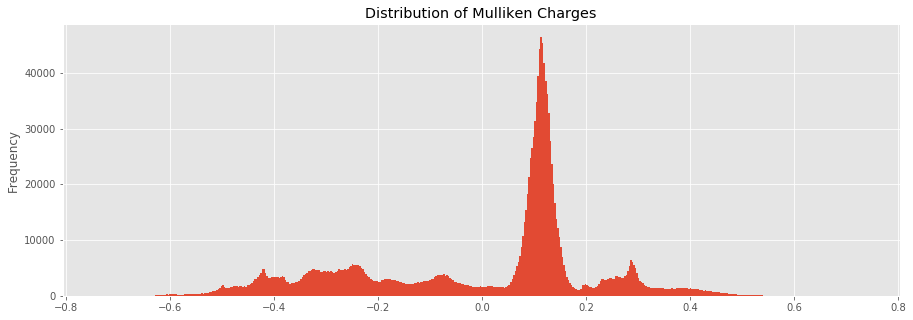

In [18]:
# Plot the distribution of mulliken_charges
mul['mulliken_charge'].plot(kind='hist', figsize=(15, 5), bins=500, title='Distribution of Mulliken Charges')
plt.show()

In [19]:
pote.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


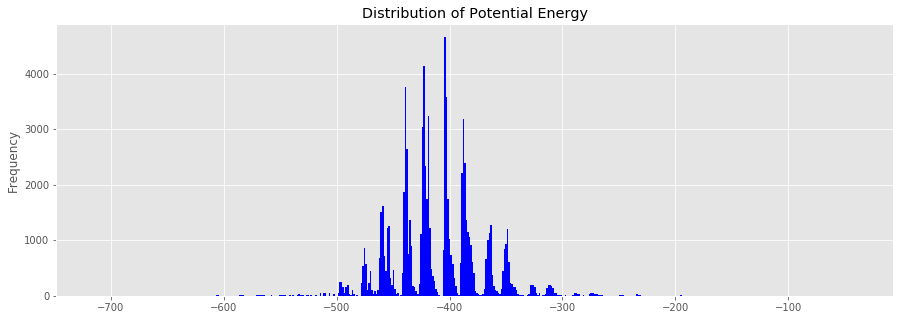

In [20]:
# Plot the distribution of potential_energy
pote['potential_energy'].plot(kind='hist',
                              figsize=(15, 5),
                              bins=500,
                              title='Distribution of Potential Energy',
                              color='b')
plt.show()

## scalar_coupling_contributions.csv
- The scalar coupling constants in train.csv (or corresponding files) are a sum of four terms. scalar_coupling_contributions.csv contain all these terms.
    - The first column (molecule_name) are the **name of the molecule**,
    - the second **(atom_index_0)** and
    - third column **(atom_index_1)** are the atom indices of the atom-pair,
    - the fourth column indicates the **type of coupling**,
    - the fifth column (fc) is the **Fermi Contact contribution**,
    - the sixth column (sd) is the **Spin-dipolar contribution**,
    - the seventh column (pso) is the **Paramagnetic spin-orbit contribution** and
    - the eighth column (dso) is the **Diamagnetic spin-orbit contribution**.

In [21]:
scc.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


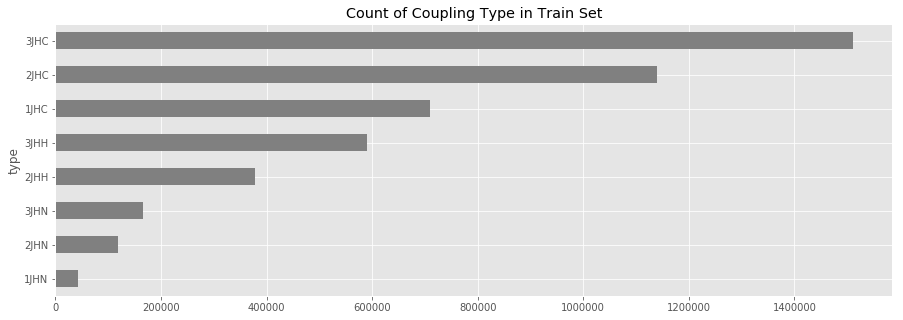

In [22]:
scc.groupby('type').count()['molecule_name'].sort_values().plot(kind='barh',
                                                                color='grey',
                                                               figsize=(15, 5),
                                                               title='Count of Coupling Type in Train Set')
plt.show()

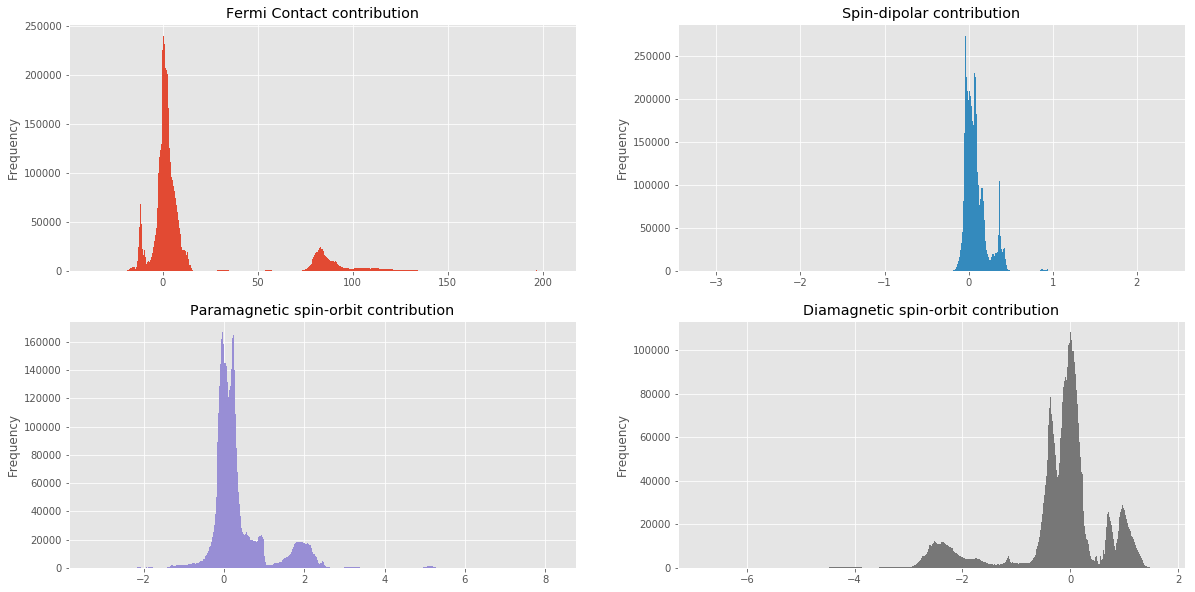

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
scc['fc'].plot(kind='hist', ax=ax.flat[0], bins=500, title='Fermi Contact contribution', color=color_pal[0])
scc['sd'].plot(kind='hist', ax=ax.flat[1], bins=500, title='Spin-dipolar contribution', color=color_pal[1])
scc['pso'].plot(kind='hist', ax=ax.flat[2], bins=500, title='Paramagnetic spin-orbit contribution', color=color_pal[2])
scc['dso'].plot(kind='hist', ax=ax.flat[3], bins=500, title='Diamagnetic spin-orbit contribution', color=color_pal[3])
plt.show()

## Relationship between Target and Features
** Keep in mind these features are provided for the training data ONLY**

In [24]:
scc = scc.merge(train_df)

These plots are beautiful. It's a shame we don't have this data for the test set.

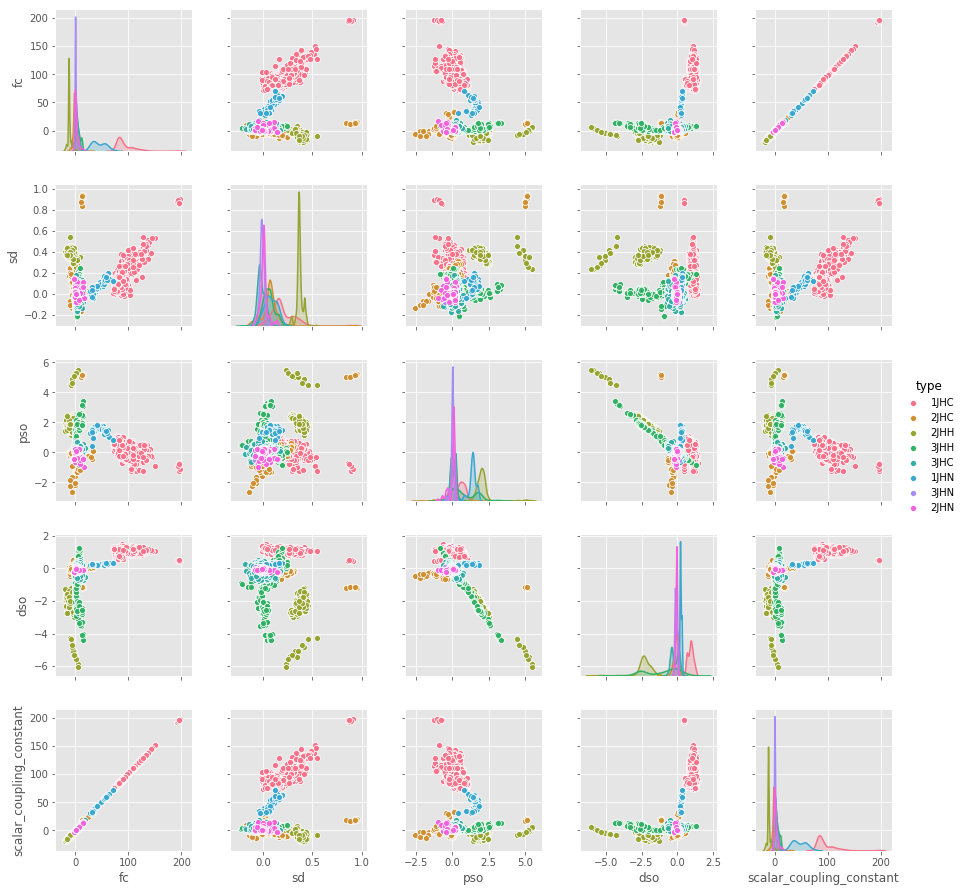

In [25]:
# Downsample to speed up plot time.
sns.pairplot(data=scc.sample(5000), hue='type', vars=['fc','sd','pso','dso','scalar_coupling_constant'])
plt.show()

## Target vs. Atom Count

In [26]:
atom_count_dict = structures.groupby('molecule_name').count()['atom_index'].to_dict()

In [27]:
train_df['atom_count'] = train_df['molecule_name'].map(atom_count_dict)
test_df['atom_count'] = test_df['molecule_name'].map(atom_count_dict)

When we look at the target `scalar_coupling_constant` in relation to the `atom_count` - there visually appears to be a relationship. We notice the gap in coupling constant values, between ~25 and ~75. It is rare to see a value within this range. Could this be a good case for a classification problem between the two clusters?

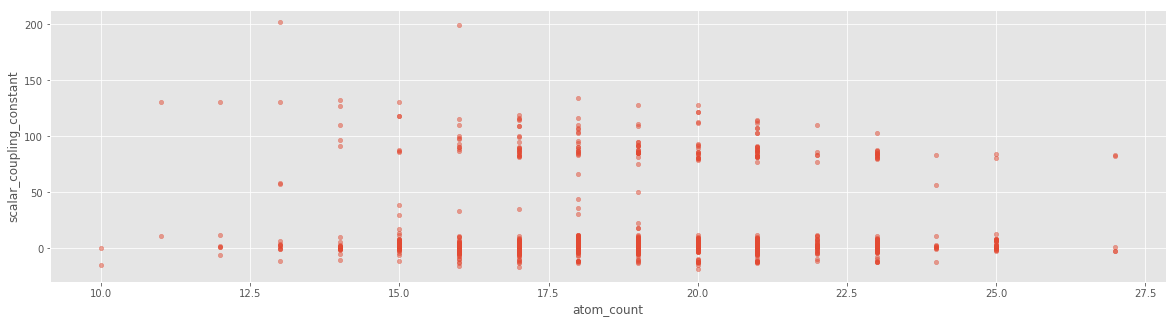

In [28]:
train_df.sample(1000).plot(x='atom_count',
                           y='scalar_coupling_constant',
                           kind='scatter',
                           color=color_pal[0],
                           figsize=(20, 5),
                           alpha=0.5)
plt.show()

# Super Simple Baseline Model [1.239 Public LB]
The simplest thing we can do as a model is predict that the target is the **average** value that we observe for that **type** in the training set!

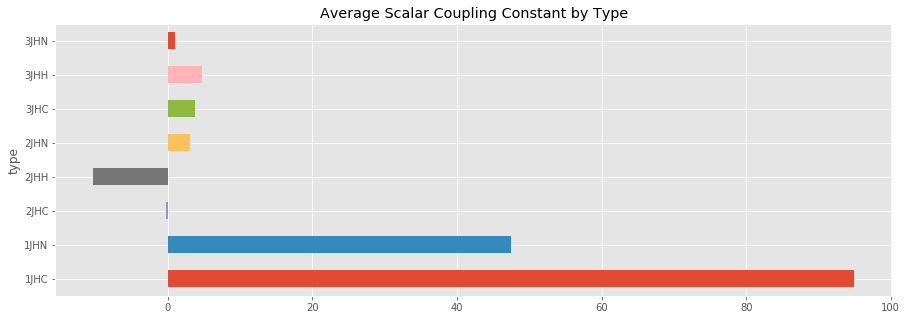

In [29]:
train_df.groupby('type')['scalar_coupling_constant'].mean().plot(kind='barh',
                                                                 figsize=(15, 5),
                                                                title='Average Scalar Coupling Constant by Type')
plt.show()
# THIS IS A MODEL!!! This is a model??
type_mean_dict = train_df.groupby('type')['scalar_coupling_constant'].mean().to_dict()
test_df['scalar_coupling_constant'] = test_df['type'].map(type_mean_dict)
test_df[['id','scalar_coupling_constant']].to_csv('super_simple_submission.csv', index=False)

# Evaluation Metric

Submissions are evaluated on the Log of the Mean Absolute Error, calculated for each scalar coupling type, and then averaged across types, so that a 1% decrease in MAE for one type provides the same improvement in score as a 1% decrease for another type.

![Eval Metric](https://i.imgur.com/AK6z3Dn.png)

Where:

- `T` is the number of scalar coupling types
- `nt` is the number of observations of type t
- `yi` is the actual scalar coupling constant for the observation
- `yi^` is the predicted scalar coupling constant for the observation

For this metric, the MAE for any group has a floor of 1e-9, so that the minimum (best) possible score for perfect predictions is approximately -20.7232.

Evaluation metric is important to understand as it determines how your model will be scored. Ideally we will set the loss function of our machine learning algorithm to use this metric so we can minimize the specific type of error.

Check out this kernel by `@abhishek` with code for the evaluation metric: https://www.kaggle.com/abhishek/competition-metric


In [30]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Feature Creation
This feature was found from `@inversion` 's kernel here: https://www.kaggle.com/inversion/atomic-distance-benchmark/output
The code was then made faster by `@seriousran` here: https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [31]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train_df = map_atom_info(train_df, 0)
train_df = map_atom_info(train_df, 1)

test_df = map_atom_info(test_df, 0)
test_df = map_atom_info(test_df, 1)

In [32]:
# https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark
train_p_0 = train_df[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_df[['x_1', 'y_1', 'z_1']].values
test_p_0 = test_df[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_df[['x_1', 'y_1', 'z_1']].values

train_df['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test_df['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

In [ ]:
# make categorical variables
atom_map = {'H': 0,
            'C': 1,
            'N': 2}
train_df['atom_0_cat'] = train_df['atom_0'].map(atom_map).astype('int')
train_df['atom_1_cat'] = train_df['atom_1'].map(atom_map).astype('int')
test_df['atom_0_cat'] = test_df['atom_0'].map(atom_map).astype('int')
test_df['atom_1_cat'] = test_df['atom_1'].map(atom_map).astype('int')

In [34]:
# One Hot Encode the Type
train_df = pd.concat([train_df, pd.get_dummies(train_df['type'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['type'])], axis=1)

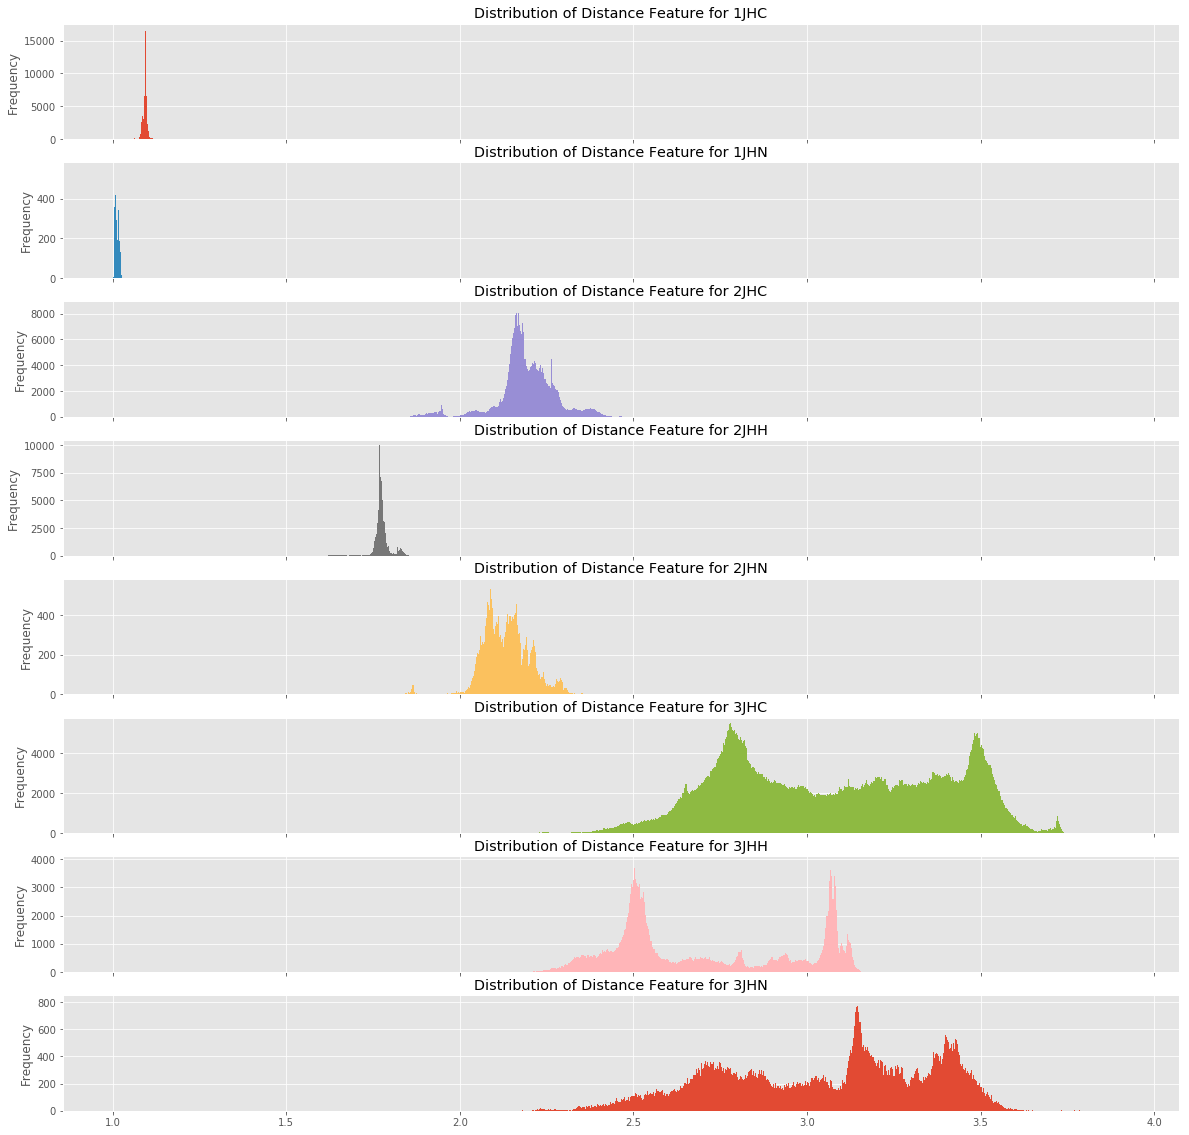

In [35]:
color_index = 0
axes_index = 0
fig, axes = plt.subplots(8, 1, figsize=(20, 20), sharex=True)
for mtype, d in train_df.groupby('type'):
    d['dist'].plot(kind='hist',
                  bins=1000,
                  title='Distribution of Distance Feature for {}'.format(mtype),
                  color=color_pal[color_index],
                  ax=axes[axes_index])
    if color_index == 6:
        color_index = 0
    else:
        color_index += 1
    axes_index += 1
plt.show()

Using the this feature from `@artgor`'s amazing kernel - https://www.kaggle.com/artgor/molecular-properties-eda-and-models

In [36]:
train_df['dist_to_type_mean'] = train_df['dist'] / train_df.groupby('type')['dist'].transform('mean')
test_df['dist_to_type_mean'] = test_df['dist'] / test_df.groupby('type')['dist'].transform('mean')

# Baseline Models
- using **atom_count** and **type** as categorical features
- Run this in a notebook to see the interactive plot of training and test error metrics.

# LightGBM - 5 Fold Cross Valified

In [37]:
# Configurables
FEATURES = ['atom_index_0', 'atom_index_1',
            'atom_0_cat',
            'x_0', 'y_0', 'z_0',
            'atom_1_cat', 
            'x_1', 'y_1', 'z_1', 'dist', 'dist_to_type_mean',
            'atom_count',
            '1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'
           ]
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['atom_0','atom_1']
N_ESTIMATORS = 2000
VERBOSE = 500
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529

X = train_df[FEATURES]
X_test = test_df[FEATURES]
y = train_df[TARGET]

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

lgb_params = {'num_leaves': 128,
              'min_child_samples': 64,
              'objective': 'regression',
              'max_depth': 6,
              'learning_rate': 0.1,
              "boosting_type": "gbdt",
              "subsample_freq": 1,
              "subsample": 0.9,
              "bagging_seed": 11,
              "metric": 'mae',
              "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.4,
              'colsample_bytree': 1.0
         }

RUN_LGB = False

if RUN_LGB:
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=RANDOM_STATE)

    # Setup arrays for storing results
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()

    # Train the model
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model = lgb.LGBMRegressor(**lgb_params, n_estimators = N_ESTIMATORS, n_jobs = -1)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='mae',
                  verbose=VERBOSE,
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = FEATURES
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        prediction /= folds.n_splits
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
        oof[valid_idx] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        prediction += y_pred

## Save LGB Results, OOF, and Feature Importance
It's always a good idea to save your OOF, predictions and feature importances. You never know when they will come in handy in the future.
I like to save the Number of folds and CV score in the filename.

In [39]:
if RUN_LGB:
    # Save Prediction and name appropriately
    submission_csv_name = 'submission_lgb_{}folds_{}CV.csv'.format(n_fold, np.mean(scores))
    oof_csv_name = 'oof_lgb_{}folds_{}CV.csv'.format(n_fold, np.mean(scores))
    fi_csv_name = 'fi_lgb_{}folds_{}CV.csv'.format(n_fold, np.mean(scores))

    print('Saving LGB Submission as:')
    print(submission_csv_name)
    ss = pd.read_csv('../input/sample_submission.csv')
    ss['scalar_coupling_constant'] = prediction
    ss.to_csv(submission_csv_name, index=False)
    ss.head()
    # OOF
    oof_df = train_df[['id','molecule_name','scalar_coupling_constant']].copy()
    oof_df['oof_pred'] = oof
    oof_df.to_csv(oof_csv_name, index=False)
    # Feature Importance
    feature_importance.to_csv(fi_csv_name, index=False)

In [40]:
if RUN_LGB:
    # Plot feature importance as done in https://www.kaggle.com/artgor/artgor-utils
    feature_importance["importance"] /= folds.n_splits
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(15, 20));
    ax = sns.barplot(x="importance",
                y="feature",
                hue='fold',
                data=best_features.sort_values(by="importance", ascending=False));
    plt.title('LGB Features (avg over folds)');

# Catboost

In [41]:
from catboost import Pool, cv

RUN_CATBOOST_CV = False

if RUN_CATBOOST_CV:
    labels = train_df['scalar_coupling_constant'].values
    cat_features = ['type','atom_count','atom_0','atom_1']
    cv_data = train_df[['type','atom_count','atom_0','atom_1',
                        'x_0','y_0','z_0','x_1','y_1','z_1','dist']]
    cv_dataset = Pool(data=cv_data,
                      label=labels,
                      cat_features=cat_features)

    ITERATIONS = 100000
    params = {"iterations": ITERATIONS,
              "learning_rate" : 0.02,
              "depth": 7,
              "loss_function": "MAE",
              "verbose": False,
              "task_type" : "GPU"}

    scores = cv(cv_dataset,
                params,
                fold_count=5, 
                plot="True")
    
    scores['iterations'] = scores['iterations'].astype('int')
    scores.set_index('iterations')[['test-MAE-mean','train-MAE-mean']].plot(figsize=(15, 5), title='CV (MAE) Score by iteration (5 Folds)')

In [42]:
from catboost import CatBoostRegressor, Pool

ITERATIONS = 200000

FEATURES = [#'atom_index_0',
            'atom_index_1',
            'atom_0',
            'x_0', 'y_0', 'z_0',
            'atom_1', 
            'x_1', 'y_1', 'z_1',
            'dist', 'dist_to_type_mean',
            'atom_count',
            'type']
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['atom_0','atom_1','type']

train_dataset = Pool(data=train_df[FEATURES],
                  label=train_df['scalar_coupling_constant'].values,
                  cat_features=CAT_FEATS)

cb_model = CatBoostRegressor(iterations=ITERATIONS,
                             learning_rate=0.2,
                             depth=7,
                             eval_metric='MAE',
                             random_seed = 529,
                             task_type="GPU")

# Fit the model
cb_model.fit(train_dataset, verbose=1000)

# Predict
test_data = test_df[FEATURES]

test_dataset = Pool(data=test_data,
                    cat_features=CAT_FEATS)

ss = pd.read_csv('../input/sample_submission.csv')
ss['scalar_coupling_constant'] = cb_model.predict(test_dataset)
ss.to_csv('basline_catboost_submission.csv', index=False)

0:	learn: 14.9282880	total: 107ms	remaining: 5h 55m 4s
1000:	learn: 2.1162185	total: 2m 6s	remaining: 7h 27s
2000:	learn: 2.0417999	total: 4m 15s	remaining: 7h 1m 47s
3000:	learn: 1.9940253	total: 6m 26s	remaining: 7h 2m 23s
4000:	learn: 1.9608044	total: 8m 37s	remaining: 7h 2m 9s
5000:	learn: 1.9335470	total: 10m 47s	remaining: 7h 56s
6000:	learn: 1.9107259	total: 12m 58s	remaining: 6h 59m 21s
7000:	learn: 1.8915343	total: 15m 9s	remaining: 6h 57m 44s
8000:	learn: 1.8742068	total: 17m 19s	remaining: 6h 55m 45s
9000:	learn: 1.8588059	total: 19m 28s	remaining: 6h 53m 25s
10000:	learn: 1.8440017	total: 21m 40s	remaining: 6h 51m 45s
11000:	learn: 1.8307776	total: 23m 51s	remaining: 6h 49m 52s
12000:	learn: 1.8183819	total: 26m 2s	remaining: 6h 47m 51s
13000:	learn: 1.8066785	total: 28m 12s	remaining: 6h 45m 49s
14000:	learn: 1.7955046	total: 30m 24s	remaining: 6h 43m 55s
15000:	learn: 1.7847443	total: 32m 36s	remaining: 6h 42m 6s
16000:	learn: 1.7745114	total: 34m 46s	remaining: 6h 39m 57

# ...more to come